# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from preprocessing import Preprocessing
from utils import evaluate_offers, create_dataset
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<br>
<br>

### Data preprocessing

In [2]:
preprocessing = Preprocessing(portfolio=portfolio, profile=profile, transcript=transcript)

In [3]:
transcript = preprocessing.run()

H:\Study\ds_nanodegree\starbucks\preprocessing.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' ... '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 'fafdcd668e3743c1bb461111dcafc2a4' 'fafdcd668e3743c1bb461111dcafc2a4']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.transcript.loc[offer_flags, 'offer_id'] = self.transcript.loc[offer_flags, 'value'].apply(
H:\Study\ds_nanodegree\starbucks\preprocessing.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[list(['web', 'email', 'mobile']) list(['web', 'email'])
 list(['web', 'email', 'mobile']) ... list(['web', 'email'])
 list(['web', 'email', 'mobile', 'social'])
 list(['web', 'email', 'mobile', 'social'])]' has dtype incompatib

In [4]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                306534 non-null  object 
 1   event                  306534 non-null  object 
 2   time                   306534 non-null  int64  
 3   offer_id               167581 non-null  object 
 4   offer_reward           167581 non-null  float64
 5   offer_channels         167581 non-null  object 
 6   offer_difficulty       167581 non-null  float64
 7   offer_duration         167581 non-null  float64
 8   offer_type             167581 non-null  object 
 9   actual_reward          306534 non-null  int64  
 10  user_gender            306534 non-null  object 
 11  user_age               306534 non-null  float64
 12  user_became_member_on  306534 non-null  int64  
 13  user_income            306534 non-null  float64
dtypes: float64(5), int64(3), object(6)
m

In [5]:
transcript.head(5)

,user_id,event,time,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,actual_reward,user_gender,user_age,user_became_member_on,user_income
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,72.0,informational,0,M,33.0,20170421,72000.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,72.0,informational,0,M,33.0,20170421,72000.0
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,NaN,NaN,NaN,NaN,NaN,0,M,33.0,20170421,72000.0
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,96.0,informational,0,M,33.0,20170421,72000.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,96.0,informational,0,M,33.0,20170421,72000.0


In [6]:
# Validation
completed = transcript.loc[transcript['event'] == 'offer completed']
completed.loc[completed['actual_reward'] != completed['offer_reward']]

,user_id,event,time,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,actual_reward,user_gender,user_age,user_became_member_on,user_income


<br>
<br>

### Figure out if offers worked or not

In [7]:
offer_results = evaluate_offers(transcript=transcript)

In [8]:
offer_results

,user_id,event,time,offer_id,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,actual_reward,user_gender,user_age,user_became_member_on,user_income,offer_result
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.0,"[email, mobile, social]",0.0,72.0,informational,0,M,33.0,20170421,72000.0,offer did not work
1,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,96.0,informational,0,M,33.0,20170421,72000.0,offer did not work
2,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,120.0,bogo,0,M,33.0,20170421,72000.0,offer worked
3,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,240.0,discount,0,M,33.0,20170421,72000.0,offer worked
4,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,168.0,discount,0,M,33.0,20170421,72000.0,purchased without offer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,240.0,discount,0,F,45.0,20161125,62000.0,offer worked
76273,ffff82501cea40309d5fdd7edcca4a07,offer received,336,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,168.0,discount,0,F,45.0,20161125,62000.0,offer worked
76274,ffff82501cea40309d5fdd7edcca4a07,offer received,408,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,168.0,discount,0,F,45.0,20161125,62000.0,offer worked
76275,ffff82501cea40309d5fdd7edcca4a07,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,168.0,bogo,0,F,45.0,20161125,62000.0,offer worked


<br>
<br>

### Feature engineering

<br>

- categorical value features: _offer_channels_, _offer_type_, _user_gender_

- numerical value features: _offer_reward_, _offer_difficulty_, _offer_duration_, _user_age_, _user_income_

- target: _offer_result_

In [9]:
dataset = create_dataset(offer_results=offer_results)
dataset

,offer_reward,offer_difficulty,offer_duration,user_age,user_income,target,channel_email,channel_mobile,channel_social,channel_web,user_gender_M,user_gender_O,offer_type_discount,offer_type_informational
0,0.0,0.0,72.0,33.0,72000.0,0,1,1,1,0,True,False,False,True
1,0.0,0.0,96.0,33.0,72000.0,0,1,1,0,1,True,False,False,True
2,5.0,5.0,120.0,33.0,72000.0,1,1,1,1,1,True,False,False,False
3,2.0,10.0,240.0,33.0,72000.0,1,1,1,1,1,True,False,True,False
4,2.0,10.0,168.0,33.0,72000.0,0,1,1,0,1,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,5.0,20.0,240.0,45.0,62000.0,1,1,0,0,1,False,False,True,False
76273,2.0,10.0,168.0,45.0,62000.0,1,1,1,0,1,False,False,True,False
76274,2.0,10.0,168.0,45.0,62000.0,1,1,1,0,1,False,False,True,False
76275,5.0,5.0,168.0,45.0,62000.0,1,1,1,0,1,False,False,False,False


In [10]:
dataset['target'].value_counts()

target
0    45492
1    30785
Name: count, dtype: int64

<br>
<br>

### Training the model

In [11]:
from sklearn.ensemble import  GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X, y = dataset.drop(columns=['target']), dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],       # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of the individual estimators
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be a leaf node
    'subsample': [0.8, 1.0]               # Fraction of samples used for fitting the individual base learners
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_gb_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_

print("Best Parameters:", best_gb_params)

# Evaluate the best model on the test set
y_pred = best_gb_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 1.0}
Accuracy on test set: 0.7791033036182485


                     Feature  Importance
0               offer_reward    0.185085
4                user_income    0.182997
12  offer_type_informational    0.127356
3                   user_age    0.110568
10             user_gender_O    0.099319
7             channel_social    0.098715
1           offer_difficulty    0.098453
2             offer_duration    0.049075
9              user_gender_M    0.030687
6             channel_mobile    0.008655


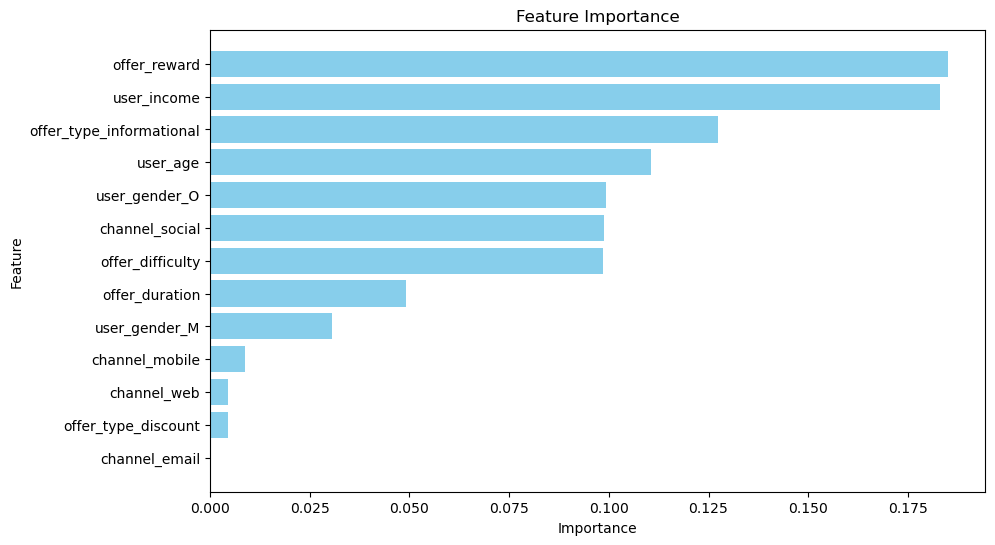

In [13]:
# Extract feature importance
feature_importances = best_gb_model.feature_importances_

# Assuming you have feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top 10 important features
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees
    'max_depth': [None, 10, 20],             # Maximum depth of trees
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]               # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_rf_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best Parameters:", best_rf_params)

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy on test set: 0.7767435762978501


                     Feature  Importance
3                   user_age    0.309689
4                user_income    0.298948
0               offer_reward    0.082810
2             offer_duration    0.072166
1           offer_difficulty    0.071831
12  offer_type_informational    0.046026
10             user_gender_O    0.042282
7             channel_social    0.036880
9              user_gender_M    0.015573
6             channel_mobile    0.011770


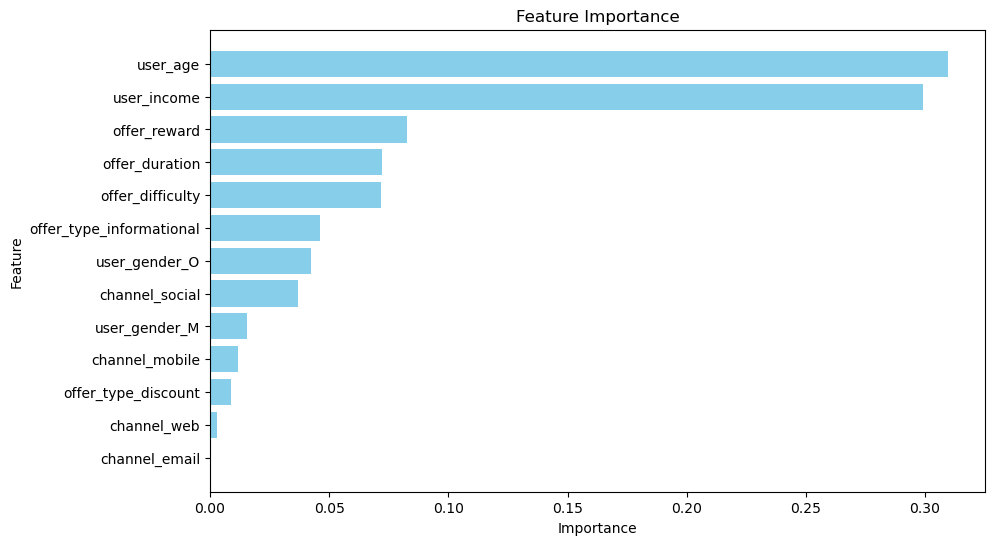

In [15]:
# Extract feature importance
feature_importances = best_rf_model.feature_importances_

# Assuming you have feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top 10 important features
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()